Potato disease prediction using VGG16

In [ ]:
import tensorflow as tf
from tensorflow .keras import models,layers
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

2024-04-06 14:50:26.492526: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-06 14:50:26.492626: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-06 14:50:26.599626: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [ ]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "/kaggle/input/potato-disease-dataset/Potato_Disease_Dataset",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [ ]:
class_names=dataset.class_names

In [ ]:
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset)

68

In [ ]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 0 0 0 1 1 2 0 0 1 0 1 0 0 1 0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 0 1]


In [ ]:
for image_batch,label_batch in dataset.take(1):
    print(image_batch[0].numpy())

[[[123. 117. 119.]
  [135. 129. 131.]
  [135. 129. 131.]
  ...
  [175. 170. 174.]
  [181. 176. 180.]
  [184. 179. 183.]]

 [[126. 120. 122.]
  [140. 134. 136.]
  [138. 132. 134.]
  ...
  [201. 196. 200.]
  [208. 203. 207.]
  [210. 205. 209.]]

 [[122. 113. 116.]
  [125. 116. 119.]
  [120. 111. 114.]
  ...
  [200. 195. 199.]
  [201. 196. 200.]
  [199. 194. 198.]]

 ...

 [[113. 103. 111.]
  [138. 128. 136.]
  [148. 138. 146.]
  ...
  [173. 170. 177.]
  [186. 183. 190.]
  [182. 179. 186.]]

 [[152. 142. 150.]
  [131. 121. 129.]
  [177. 167. 175.]
  ...
  [172. 169. 176.]
  [187. 184. 191.]
  [188. 185. 192.]]

 [[162. 152. 160.]
  [124. 114. 122.]
  [163. 153. 161.]
  ...
  [178. 175. 182.]
  [190. 187. 194.]
  [189. 186. 193.]]]


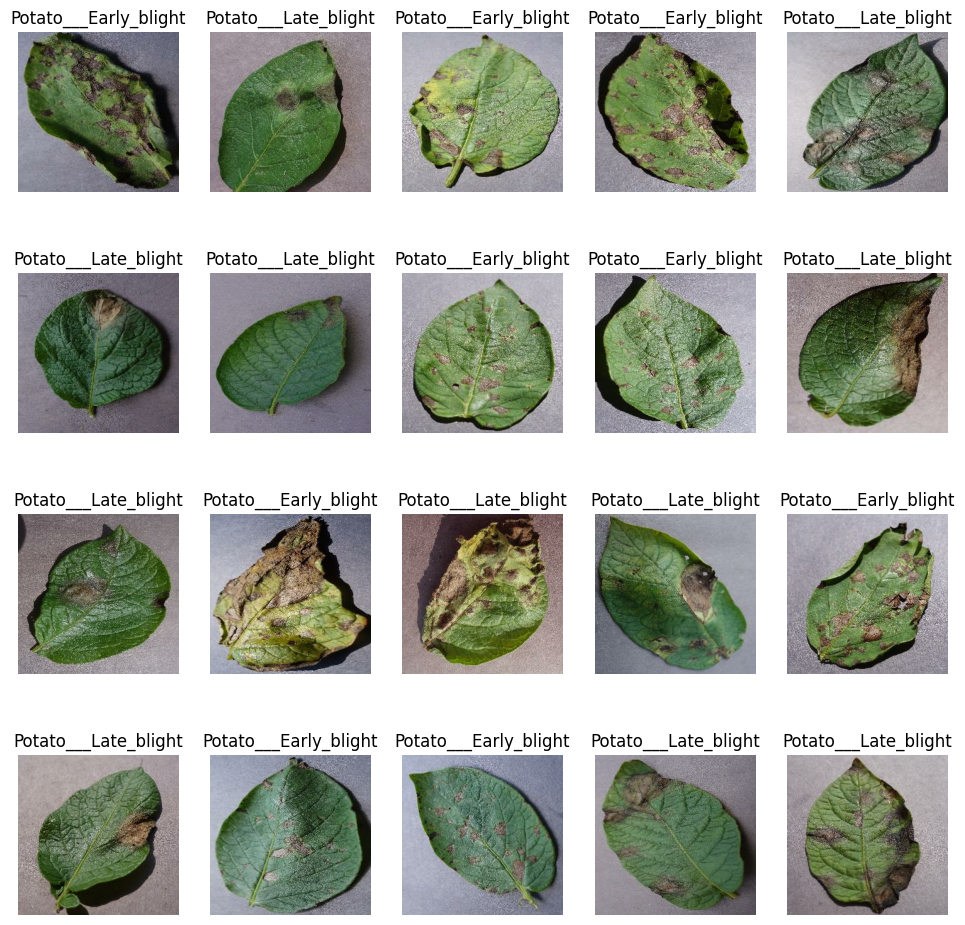

In [ ]:
plt.figure(figsize=(12,12))
for image_batch,label_batch in dataset.take(1):
    for i in range(20):
        ax=plt.subplot(4,5,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

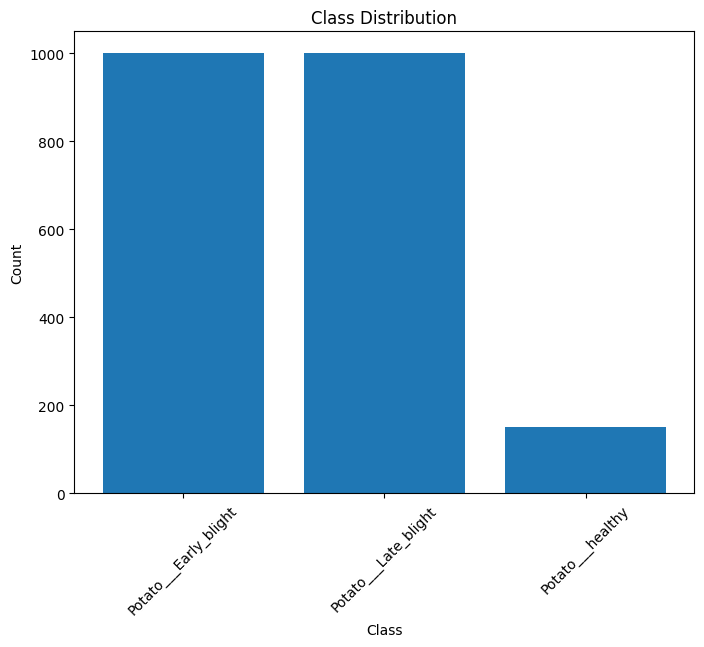

In [ ]:
#It willl perform class distribution
plt.figure(figsize=(8, 6))
class_counts = [0] * len(class_names)
for _, labels in dataset:
    for label in labels.numpy():
        class_counts[label] += 1
plt.bar(class_names, class_counts)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.show()


In [ ]:
# Compute and visualize mean and standard deviation of pixel values
mean_pixels = []
std_pixels = []
for images, _ in dataset:
    mean_pixels.append(tf.math.reduce_mean(images, axis=[0, 1, 2]))
    std_pixels.append(tf.math.reduce_std(images, axis=[0, 1, 2]))

mean_pixels = tf.math.reduce_mean(mean_pixels, axis=0)
std_pixels = tf.math.reduce_mean(std_pixels, axis=0)
print("Mean pixel values:", mean_pixels.numpy())
print("Standard deviation of pixel values:", std_pixels.numpy())


Mean pixel values: [125.92179 130.39432 108.81758]
Standard deviation of pixel values: [48.84416  45.308548 54.689064]


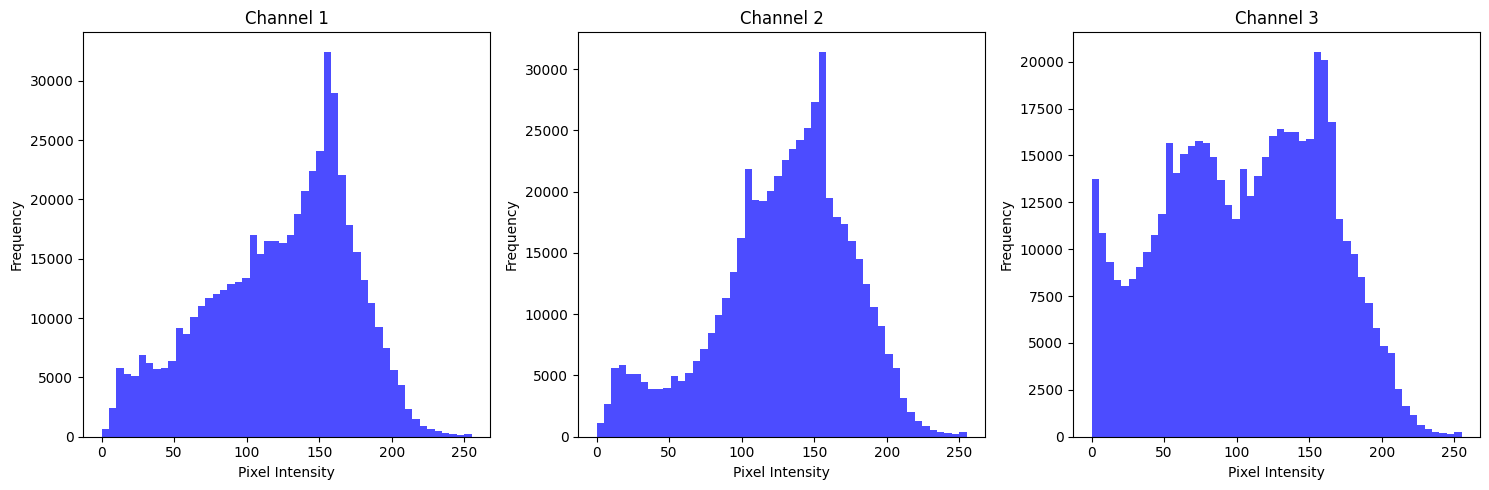

In [ ]:
# Plot histogram of pixel intensities for each channel
plt.figure(figsize=(15, 5))
for i in range(CHANNELS):
    plt.subplot(1, CHANNELS, i + 1)
    plt.hist(images[:, :, :, i].numpy().flatten(), bins=50, color='blue', alpha=0.7)
    plt.title(f'Channel {i+1}')
    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
#Split dataset into train_ds,val_ds,test_ds.
def get_dataset_partition_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,shuffle_size=10000):
    ds_size=len(ds)
    if shuffle:
        ds=ds.shuffle(shuffle_size,seed=121)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    train_ds=ds.take(train_size)
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    return train_ds,val_ds,test_ds

In [ ]:
train_ds,val_ds,test_ds=get_dataset_partition_tf(dataset)

In [ ]:
len(train_ds)

54

In [ ]:
len(val_ds)

6

In [ ]:
len(test_ds)

8

In [ ]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
resize_and_rescale=tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255)
])

In [ ]:
data_augmentation=tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2)
])

In [ ]:
resize_and_rescale

<Sequential name=sequential, built=False>

In [ ]:

data_augmentation

<Sequential name=sequential_1, built=False>

In [ ]:
IMAGE_SIZE

256

In [ ]:
input_shape=(BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes=3

In [ ]:
#VggNet
from tensorflow.keras.applications import VGG16


In [ ]:
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


In [ ]:
base_model.trainable = False


In [ ]:
model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    base_model,
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(n_classes, activation='softmax')
])

In [ ]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (32, 256, 256, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vgg16 (Functional)              │ ?                      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
history=model.fit(train_ds,batch_size=BATCH_SIZE,validation_data=val_ds,verbose=1,epochs=EPOCHS)

Epoch 1/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 17s 162ms/step - accuracy: 0.6020 - loss: 3.2010 - val_accuracy: 0.9167 - val_loss: 0.3017
Epoch 2/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.8638 - loss: 0.3512 - val_accuracy: 0.9271 - val_loss: 0.2161
Epoch 3/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.8875 - loss: 0.3012 - val_accuracy: 0.9323 - val_loss: 0.2524
Epoch 4/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.8705 - loss: 0.2998 - val_accuracy: 0.9115 - val_loss: 0.1818
Epoch 5/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.8879 - loss: 0.2698 - val_accuracy: 0.9635 - val_loss: 0.1722
Epoch 6/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.9112 - loss: 0.2379 - val_accuracy: 0.9427 - val_loss: 0.1443
Epoch 7/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.8809 - loss: 0.2654 - val_accuracy: 0.9271 - val_loss: 0.1511
Epoch 8/50
54/54 ━━━━━━━━━━━━━━━━━━━━ 6s 119ms/step - accuracy: 0.9172 - loss: 0.2286 - val_accuracy: 0

In [ ]:
scores=model.evaluate(test_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 106ms/step - accuracy: 0.9934 - loss: 0.0454


In [ ]:
scores

[0.06906069815158844, 0.984375]

In [ ]:
accuracy=history.history['accuracy']
val_accuracy=history.history['val_accuracy']
loss=history.history['loss']
val_loss=history.history['val_loss']


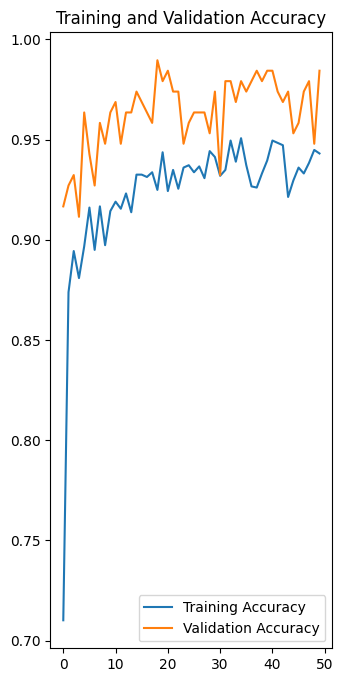

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),accuracy,label='Training Accuracy')
plt.plot(range(EPOCHS),val_accuracy,label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title("Training and Validation Accuracy")
plt.show()

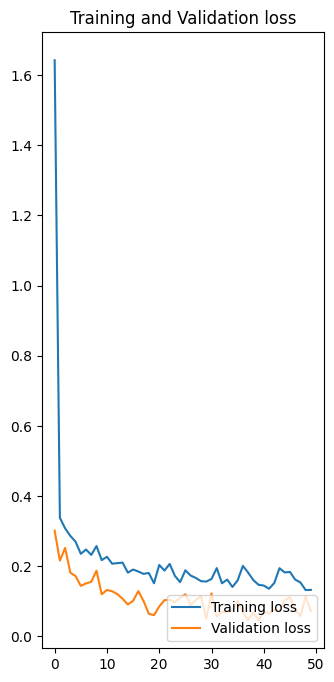

In [ ]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS),loss,label='Training loss')
plt.plot(range(EPOCHS),val_loss,label='Validation loss')
plt.legend(loc='lower right')
plt.title("Training and Validation loss")
plt.show()

First Image to predict
Actual Label: Potato___Late_blight
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 187ms/step
Predicted Label: Potato___Late_blight


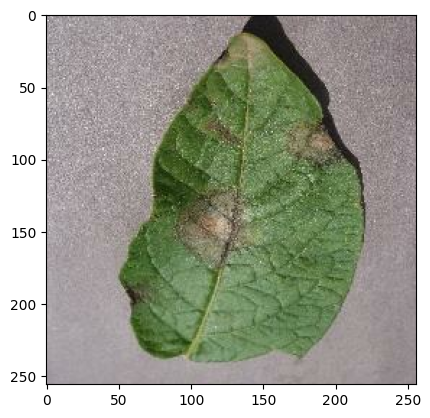

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):
    first_image=images_batch[0].numpy().astype("uint8")
    print("First Image to predict")
    plt.imshow(first_image)
    print("Actual Label:",class_names[labels_batch[0].numpy()])

    batch_prediction=model.predict(images_batch)
    print("Predicted Label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model,img):
    img_array=tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array=tf.expand_dims(img_array,0)

    predictions=model.predict(img_array)

    predicted_class=class_names[np.argmax(predictions[0])]
    confidence=round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 758ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step


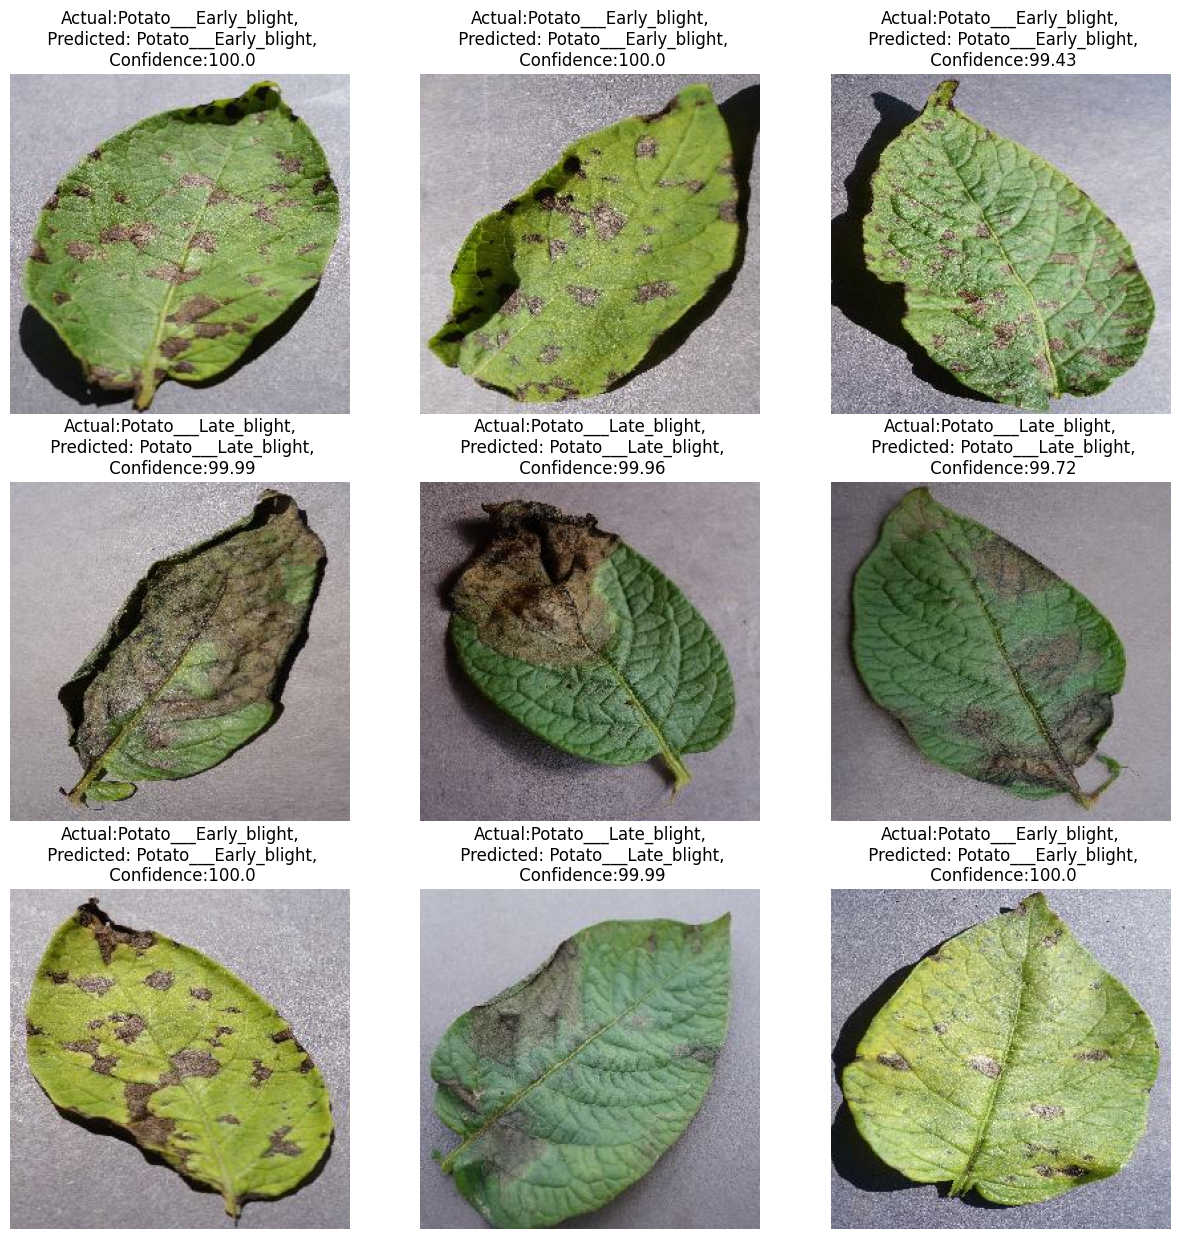

In [ ]:
plt.figure(figsize=(15,15))
for images,labels in test_ds.take(1):
    for i in range(9):
        ax=plt.subplot(3,3,i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class,confidence=predict(model,images[i].numpy())

        actual_class =class_names[labels[i]]
        plt.title(f"Actual:{actual_class},\n Predicted: {predicted_class},\n Confidence:{confidence}")
        plt.axis("off")